In [0]:
# This code was developed using ideas from the following sources:

# DCGAN Adventures with Cifar10 by Stepan Ulyanin
# Deep Convolutional Generative Adversarial Network Tensorflow Tutorial
# How to Develop a GAN to Generate CIFAR10 Small Color Photographs by Jason Brownlee
# Having Fun with Deep Convolutional GANs by Naoki Shibuya

In [0]:
# Import necessary libraries
# Neural net will be constructed using tensorflow.keras

from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import numpy as np
from tensorflow import keras
# from tensorflow.keras import layers
from matplotlib import pyplot
import tensorflow_datasets as tfds

In [0]:
# Some helper functions for manipulating CIFAR10 data

# select random real samples to be classified by discriminator
def real_samples(data,n_samples):
  # data is the CIFAR10 dataset
  # take random elements from the dataset
  x = np.random.randint(0,data.shape[0],n_samples)
  X = data[x] #this is the corresponding image
  y = np.ones((n_samples,1)) # this classifies the X value as a real image
  return X , y

# given fake points in latent space, generate some fake images to give to discriminator
def make_fake_samples(generator,lat_dim,n_samples):
  x_in = np.random.randn(n_samples,lat_dim)
  # given the input, the generator model uses the Keras function 'predict' to \\
  #   produce outputs (like our FeedForward technique from class)
  X = generator.predict(x_in)
  # we label these outputs as fake, for classifying with the discriminator
  y = np.zeros((n_samples,1))
  return X , y


In [0]:
# Some more functions for displaying and measuring the network

# save a plot of fake images after a certain number of epochs
def save_plot(images,epoch,n=5):
  # scale images to an appropriate range for imshow:
  images = (images+1.0)/2 

  for i in range(n**2):
    pyplot.subplot(n,n,i+1); pyplot.axis('off')
    pyplot.imshow(images[i])
  
  #save the images
  file1 = 'plot_fakes_epoch{}.png'.format(epoch+1)
  pyplot.savefig(file1)
  pyplot.close()

def percent_correct(epoch,generator,discriminator,data,lat_dim,n_samples=100):
  
  X_true,y_true = real_samples(data,n_samples)
  # Check how good the discriminator is at identifying true samples
  c1, accuracy_true = discriminator.evaluate(X_true,y_true,verbose=0)

  X_false,y_false = make_fake_samples(generator,lat_dim,n_samples)
  # Check how good the discriminator is at identifying false samples
  c2, accuracy_false = discriminator.evaluate(X_false,y_false,verbose=0)

  print('Accuracy with real samples: {}%, fake samples: {}%'.format(accuracy_true*100,accuracy_false*100))

  save_plot(X_false,epoch)

  # we can save the current model parameters using keras:
  # generator.save('generator_model_epoch_{}.h5'.format(epoch+1))


In [0]:
# construct the generator, discriminator, and the full neural net by combining them

# First the discriminator model, which takes in a 32x32x3 image.
#  We use Conv2D to build layers. We can construct Conv2D in a way such that it
#  Reduces the x,y dimensions of the previous layer by half. The parameters 
#  'kernel', 'strides' and 'padding will change the size of the next layer. Literature
#  recommends using kernel = (3,3) for this problem.
#  Example: given an input layer with dimensions (64,64,128).
#           Conv2D(256,(3,3), strides = (2,2)) will give dimensions (62,62,256)
#           Conv2D(128,(3,3), strides = (2,2),padding = 'same') 
#                                      will give dimensions (32,32,128)

def build_discriminator(shape_in = (32,32,3)):
  disc_model = keras.Sequential()

  # add the first layer. kernel_size = (3,3) is recommended in documentation 
  #   size becomes (32x32x64)
  disc_model.add(keras.layers.Conv2D(64, (3,3), padding='same', input_shape = shape_in))
  disc_model.add(keras.layers.LeakyReLU(alpha=0.2)) #try 0.3 or 0.2

  # sample down with the next layer
  #   size becomes (16x16x128)
  disc_model.add(keras.layers.Conv2D(128, (3,3), strides = (2,2), padding='same'))
  disc_model.add(keras.layers.LeakyReLU(alpha=0.2)) #try 0.3 or 0.2

  # sample down with the next layer
  #   size becomes (8x8x128)
  disc_model.add(keras.layers.Conv2D(128, (3,3), strides = (2,2), padding='same'))
  disc_model.add(keras.layers.LeakyReLU(alpha=0.2)) #try 0.3 or 0.2

  # sample down with the next layer
  #   size becomes (4x4x256)
  disc_model.add(keras.layers.Conv2D(256, (3,3), strides = (2,2), padding='same'))
  disc_model.add(keras.layers.LeakyReLU(alpha=0.2)) #try 0.3 or 0.2

  # finally the classification layer
  disc_model.add(keras.layers.Flatten())
  # recommended to add some dropout
  disc_model.add(keras.layers.Dropout(0.4))
  # use logistic activation at classification layer
  #   size is (1)
  disc_model.add(keras.layers.Dense(1,activation='sigmoid'))

  # define optimizer. Recommended to use Adam for DCGANs
  opt = keras.optimizers.Adam(learning_rate=0.0005,beta_1=0.5) #try lr = 0.0002 or 0.001
  disc_model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

  return disc_model

# next the generator model
# Here we use Conv2DTranspose, and instead of downsampling the dimension of our
#  layers, it upsamples. so we can instead go from (4,4,256) to (8,8,128). The
#  parameters are largely the same otherwise.
def build_generator(lat_dim):
  # lat_dim is the dimension of the latent space (usually lat_dim=100)
  gen_model = keras.Sequential()

  # starting with input of size lat_dim, upsample to get 32x32x3 image
  # leakyReLU activation function on each layer

  # first we add a 4x4x256 layer. This size comes from trial and error.
  gen_model.add(keras.layers.Dense(4*4*256,input_dim=lat_dim))
  gen_model.add(keras.layers.LeakyReLU(alpha=0.2)) #try 0.3 or 0.2
  # reshape to get 4x4x256
  gen_model.add(keras.layers.Reshape((4,4,256)))

  # add another layer, with dimension (8x8x128)
  gen_model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  gen_model.add(keras.layers.LeakyReLU(alpha=0.2)) #try 0.3 or 0.2

  # add another layer, with dimension (16x16x128) 
  gen_model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  gen_model.add(keras.layers.LeakyReLU(alpha=0.2)) #try 0.3 or 0.2

  # add another layer,, with dimension (32x32x128) 
  gen_model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  gen_model.add(keras.layers.LeakyReLU(alpha=0.2)) #try 0.3 or 0.2

  # add output layer with dimension (32x32x3). use Tanh as output activation
  gen_model.add(keras.layers.Conv2D(3, (3,3), activation = 'tanh', padding = 'same' ))

  return gen_model

# now we put them together
def build_dcgan(gen_model,disc_model):
  # don't train weights in discriminator
  disc_model.trainable = False

  gan_model = keras.Sequential()

  gan_model.add(gen_model)
  gan_model.add(disc_model)

  opt = keras.optimizers.Adam(lr=0.0005,beta_1=0.5) #try lr = 0.0002 or 0.001
  gan_model.compile(loss='binary_crossentropy',optimizer=opt)

  return gan_model




In [0]:
# now we can train our gan model

def train(generator,discriminator,gan_model,data,lat_dim,epochs=100,n_batches=128):
  batch_per_epoch = int(data.shape[0]/n_batches)

  for i in range(epochs):
    for j in range(batch_per_epoch):
      X_true,y_true = real_samples(data,int(n_batches/2))
      disc_loss1,_ = discriminator.train_on_batch(X_true,y_true)

      X_false,y_false = make_fake_samples(generator, lat_dim, int(n_batches/2))
      disc_loss2, _ = discriminator.train_on_batch(X_false,y_false)

      X_generator = np.random.randn(n_batches,lat_dim)
      y_generator = np.ones((n_batches,1))

      gan_loss = gan_model.train_on_batch(X_generator,y_generator)

    print('epoch = {}, Loss = {}'.format(i+1,gan_loss))
    if (i+1) % 20 == 0:
      percent_correct(i,generator,discriminator,data,lat_dim,n_samples=100)

    

In [0]:
# load the data in from keras.datasets
(data,_),(_,_) = keras.datasets.cifar10.load_data()
# Each element of data has dimension 32x32x3
# Convert data to from ints to floats
data = data.astype('float32')
# Map image data from [0,255] to [-1,1]
data = (data-127.5) / 127.5

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
# now we will build our model:
lat_dim = 100
disc_model = build_discriminator()
gen_model = build_generator(lat_dim)
gan_model = build_dcgan(gen_model,disc_model)



In [0]:
#train(gen_model,disc_model,gan_model,data,lat_dim,epochs=60)
train(gen_model,disc_model,gan_model,data,lat_dim,epochs=40)

epoch = 1, Loss = 1.4786581993103027
epoch = 2, Loss = 1.3356153964996338
epoch = 3, Loss = 1.823489785194397
epoch = 4, Loss = 1.069258451461792
epoch = 5, Loss = 1.4037681818008423
epoch = 6, Loss = 1.203444480895996
epoch = 7, Loss = 0.9942808151245117
epoch = 8, Loss = 0.974218487739563
epoch = 9, Loss = 0.9651796221733093
epoch = 10, Loss = 0.9097118377685547
epoch = 11, Loss = 0.9104885458946228
epoch = 12, Loss = 0.9339446425437927
epoch = 13, Loss = 0.8983970880508423
epoch = 14, Loss = 0.9262967109680176
epoch = 15, Loss = 0.9045497179031372
epoch = 16, Loss = 0.8115934133529663
epoch = 17, Loss = 0.8703876733779907
epoch = 18, Loss = 0.8550608158111572
epoch = 19, Loss = 0.8316008448600769
epoch = 20, Loss = 0.8889588713645935
Accuracy with real samples: 41.999998688697815%, fake samples: 75.99999904632568%
epoch = 21, Loss = 0.8934224247932434
epoch = 22, Loss = 0.8794540166854858
epoch = 23, Loss = 0.8227217197418213
epoch = 24, Loss = 0.8333544731140137
epoch = 25, Loss = 

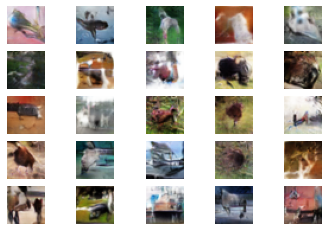

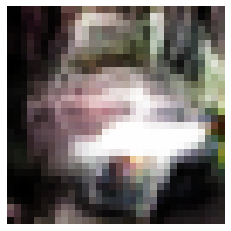

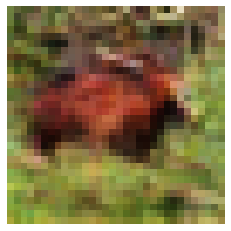

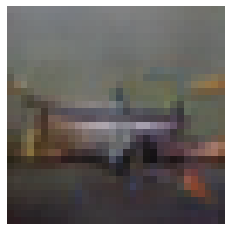

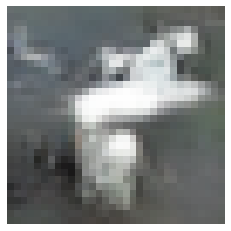

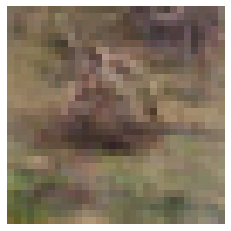

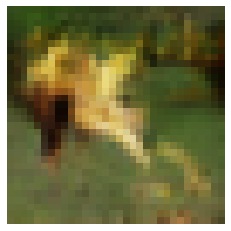

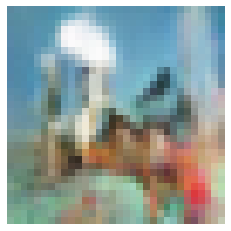

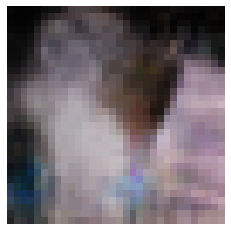

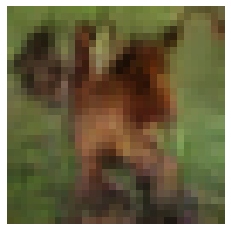

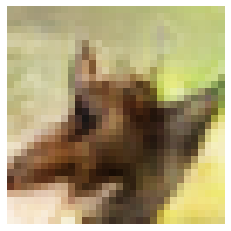

In [0]:
from keras.models import load_model

def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# generate images
latent_points = np.random.randn(100,100)
# generate images
X = gen_model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 5)

for i in range(10):
  P = np.random.randn(1, 100)
  # load_model('generator_model_epoch_100.h5')
  X = gen_model.predict(P)
  X = (X + 1) / 2.0
  create_plot(X, 1)


In [0]:
#gen_model.summary()
#disc_model.summary()
#gan_model.summary()

In [0]:
#X_true,y_true = real_samples(data,100)
  # Check how good the discriminator is at identifying true samples
#c1, accuracy_true = disc_model.evaluate(X_true,y_true,verbose=0)

#X_false,y_false = make_fake_samples(gen_model,lat_dim,100)
  # Check how good the discriminator is at identifying false samples
#c2, accuracy_false = disc_model.evaluate(X_false,y_false,verbose=0)

#print('Accuracy with real samples: {}%, fake samples: {}%'.format(accuracy_true*100,accuracy_false*100))

In [0]:
#def conv2dAnalysis(shape_in = (32,32,3)):
#  model = keras.Sequential()

  # add the first layer. kernel_size = (3,3) is recommended in documentation 
  #   size becomes (32x32x64)
#  model.add(keras.layers.Conv2D(64, (3,3),  input_shape = shape_in))
#  model.add(keras.layers.LeakyReLU(alpha=0.2))

  # sample down with the next layer
  #   size becomes (16x16x128)
#  model.add(keras.layers.Conv2D(128, (5,5), strides = (1,1)))
#  model.add(keras.layers.LeakyReLU(alpha=0.2))

  # sample down with the next layer
  #   size becomes (8x8x128)
#  model.add(keras.layers.Conv2D(128, (3,3), strides = (2,2)))
#  model.add(keras.layers.LeakyReLU(alpha=0.2))

#  model.add(keras.layers.Conv2DTranspose(128, (5,5), strides=(1,1)))
#  model.add(keras.layers.LeakyReLU(alpha=0.2))

  # sample down with the next layer
  #   size becomes (4x4x256)
#  model.add(keras.layers.Conv2D(256, (3,3), strides = (1,1)))
#  model.add(keras.layers.LeakyReLU(alpha=0.2))

  # finally the classification layer
#  model.add(keras.layers.Flatten())
  # recommended to add some dropout
#  model.add(keras.layers.Dropout(0.4))
  # use logistic activation at classification layer
  #   size is (1)
#  model.add(keras.layers.Dense(1,activation='sigmoid'))

  # define optimizer. Recommended to use Adam for DCGANs
#  opt = keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5)
#  model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

#  return model

#disc = conv2dAnalysis()
#disc.summary()


In [0]:
# Uncomment to save the model

#gen_model.compile()
#gen_model.save('generator100e.h5')
#gan_model.save('dcgan100.h5')

# Recreate the exact same model purely from the file
#new_model = keras.models.load_model('generator100e.h5')

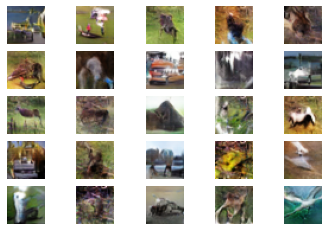

In [0]:
latent_points = np.random.randn(100,100)
# generate images
X = new_model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 5)

In [0]:
import matplotlib.pyplot as plt
N = 100
latent_points = np.random.randn(N,100)
# generate images
X = new_model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

#for i in range(20):
#  plt.figure(i,figsize=(2,2))
#  plt.imshow(X[i, :, :]);plt.axis('off');plt.title('Figure {}'.format(i))

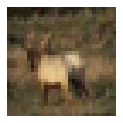

In [0]:
newdata = (data+1)/2
plt.figure(1,figsize=(2,2))
plt.imshow(newdata[3,:,:]);plt.axis('off');

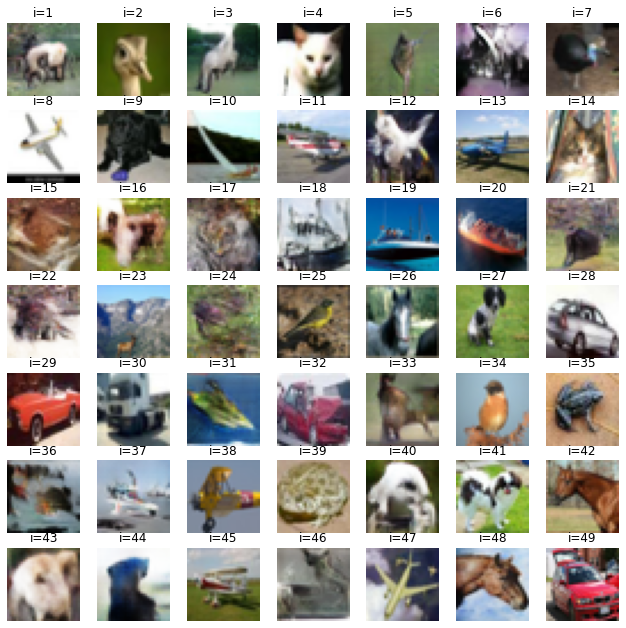

In [0]:
n = 7
N = 100
latent_points = np.random.randn(N,100)
# generate images
X = new_model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
fakes = ''

plt.figure(figsize = (11,11))
for i in range(n**2):
  j = np.random.randint(0,3000)
  plt.subplot(n,n,i+1);
  plt.axis('off')
  if j % 2 == 0:
    plt.imshow(X[i, :, :]);
    fakes += 'f'
  else:
    plt.imshow(newdata[j, :, :]);
    fakes += 'r'
  plt.title('i={}'.format(i+1))

plt.show()


In [0]:
guesses = 'fffrfrrrfrfrfffrrrrfrffrr'
correct_real = 0
total_real = 0
correct_fake = 0
total_fake = 0

for i in range(len(fakes)):
  if fakes[i] == 'r':
    total_real += 1
    if guesses[i]==fakes[i]:
      correct_real += 1;
  else:
    total_fake += 1
    if guesses[i]==fakes[i]:
      correct_fake += 1;
    else:
      print(i+1)
    
print(correct_real/total_real,correct_fake/total_fake)


4
7
0.9166666666666666 0.8461538461538461


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)      

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import numpy as np
from tensorflow import keras
# from tensorflow.keras import layers
from matplotlib import pyplot

In [0]:
fake_image = np.load('/content/gdrive/My Drive/DCGAN/dcgan_new_100e.h5')

print(fake_image.shape)

FileNotFoundError: ignored